In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
## Matplotlib defaults ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Overview

Analyze assembly index calculations across patent data. These calculations are from random samples of compounds present in each month from 1980-2019.

//TODO: sample from new compounds added in each month

In [3]:
fp = "Data/AssemblyValues/assembly_values_1000_1980.p"
assembly_values = pickle.load(file=open(fp, "rb"))

In [4]:
print(assembly_values[100:199])

[{'month': '1980-01', 'inchi': 'InChI=1S/C17H35Cl.H3N/c1-5-6-7-8-9-10-11-12-13-14-15-16(2)17(3,4)18;/h16H,5-15H2,1-4H3;1H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-16-10-25(11-17(2)22(16)7)28(26-12-18(3)23(8)19(4)13-26)27-14-20(5)24(9)21(6)15-27/h10-15H,1-9H3', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C27H33P/c1-7-22-10-19(4)13-25(16-22)28(26-14-20(5)11-23(8-2)17-26)27-15-21(6)12-24(9-3)18-27/h10-18H,7-9H2,1-6H3', 'ai': 16}, {'month': '1980-01', 'inchi': 'InChI=1S/C30H39P/c1-28(2,3)22-13-10-16-25(19-22)31(26-17-11-14-23(20-26)29(4,5)6)27-18-12-15-24(21-27)30(7,8)9/h10-21H,1-9H3', 'ai': 20}, {'month': '1980-01', 'inchi': 'InChI=1S/C18H31N/c1-2-3-4-5-15-6-10-17(11-7-15)18-12-8-16(14-19)9-13-18/h15-18H,2-13H2,1H3', 'ai': 9}, {'month': '1980-01', 'inchi': 'InChI=1S/C16H17NO2/c18-16(19)14-10-4-5-11-15(14)17-12-6-9-13-7-2-1-3-8-13/h1-5,7-8,10-11,17H,6,9,12H2,(H,18,19)', 'ai': 14}, {'month': '1980-01', 'inchi': 'InChI=1S/C20H32O2/c1-12-10-14(21)11-13-4-5-15-16

In [5]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [12]:
months = build_month_increments(1980, 1980)
print(months)

['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12']


## Assembly values Analysis

There are varying numbers of compounds for each month - so it's necessary to make separate lists for each month. These are stored in a dictionary {month: [assembly values]}

In [28]:
#Create a dictionary of months & assembly indices
month_ais = {}

#Full function for many-year analysis
for year in tqdm(range(1980,1987)):
    #Build months associated with each year
    months = build_month_increments(year, year)
    
    #Add AI for each month
    for month in months:
        ais = []
        
        #Load assembly values
        fp = "Data/AssemblyValues/assembly_values_1000_" + str(year) + ".p"
        assembly_values = pickle.load(file=open(fp, "rb"))
        
        for cpd in assembly_values:
            if cpd["month"] == month:
                ais.append(cpd["ai"])

        month_ais[month] = ais
        
print(month_ais.keys())

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  3.46it/s]

dict_keys(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08', '1980-09', '1980-10', '1980-11', '1980-12', '1981-01', '1981-02', '1981-03', '1981-04', '1981-05', '1981-06', '1981-07', '1981-08', '1981-09', '1981-10', '1981-11', '1981-12', '1982-01', '1982-02', '1982-03', '1982-04', '1982-05', '1982-06', '1982-07', '1982-08', '1982-09', '1982-10', '1982-11', '1982-12', '1983-01', '1983-02', '1983-03', '1983-04', '1983-05', '1983-06', '1983-07', '1983-08', '1983-09', '1983-10', '1983-11', '1983-12', '1984-01', '1984-02', '1984-03', '1984-04', '1984-05', '1984-06', '1984-07', '1984-08', '1984-09', '1984-10', '1984-11', '1984-12', '1985-01', '1985-02', '1985-03', '1985-04', '1985-05', '1985-06', '1985-07', '1985-08', '1985-09', '1985-10', '1985-11', '1985-12', '1986-01', '1986-02', '1986-03', '1986-04', '1986-05', '1986-06', '1986-07', '1986-08', '1986-09', '1986-10', '1986-11', '1986-12'])


In [29]:
#Find average & standard deviation for each month
month_avgs = []
month_stds = []
for month, ais in month_ais.items():
    month_avgs.append(np.mean(ais))
    month_stds.append(np.std(ais))


## Assembly values plotting

Plot mean, standard deviation, other data for each month

Text(0, 0.5, 'Assembly Index')

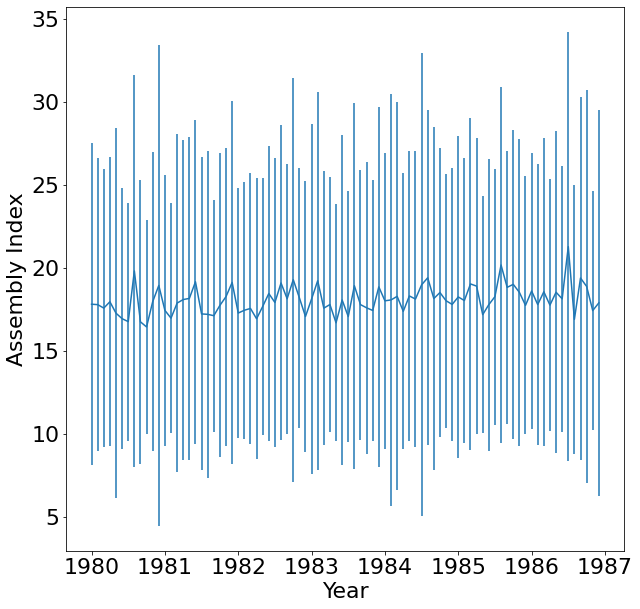

In [30]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))
plt.errorbar(np.arange(1980, 1987, 1/12), month_avgs, yerr=month_stds)

plt.xlabel("Year")
plt.ylabel("Assembly Index")

Text(0, 0.5, 'Assembly Index')

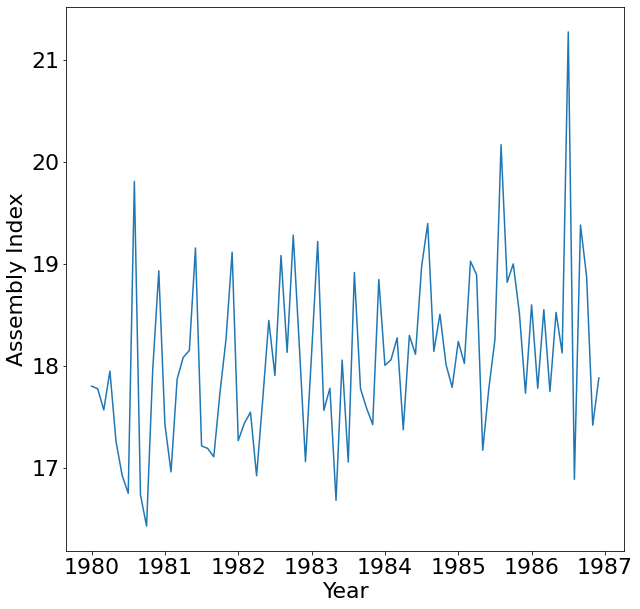

In [31]:
#Assembly values without standard deviation
plt.figure(figsize=(10,10))
plt.plot(np.arange(1980, 1987, 1/12), month_avgs)

plt.xlabel("Year")
plt.ylabel("Assembly Index")